In [5]:
import numpy as np

def normalize_axis(a: np.ndarray):
    """
    Make sure the matrix has two dimension
    """
    if len(a.shape) == 1:
        return np.expand_dims(a, axis=1)
    else:
        return a

def build_matrix(x: np.ndarray):
    return np.c_[np.ones((len(x), 1)), x]
def mse_loss(a, b):
    return np.mean((a - b) ** 2)

def load_npz(path: str):
    data = np.load(path)
    x, y  = data['X'], data['y']
    x = normalize_axis(x)
    y = normalize_axis(y)
    return x, y
def split_data(x, y, split_ratio = 0.9, seed=456):
    np.random.seed(seed)
    np.random.shuffle(x)
    np.random.seed(seed)
    np.random.shuffle(y)

    num_sample = len(x)
    interval = int(num_sample * split_ratio)
    x_train, y_train = x[:interval,...], y[:interval,...]
    x_test, y_test = x[interval:,...], y[interval:,...]

    return (x_train, y_train), (x_test, y_test)
x, y = load_npz('./data1.npz')
(x_train, y_train), (x_test, y_test) = split_data(x, y)

In [2]:
import matplotlib.pyplot as plt
class Local_weighted_linear_regressor(object):
    def __init__(self, kernel_width:int=10):
        self.x = None
        self.y = None
        self.kernel_width = kernel_width
    def weighted(self, query_x:np.ndarray):
        k_coff = 4 / (self.kernel_width ** 2)

        query_x = normalize_axis(query_x)
        num_x = len(self.x)
        distance = np.sum((query_x[:,np.newaxis,:] - self.x[np.newaxis,:,:]) ** 2, axis=-1)
        weights = []

        identity_mask = (np.identity(num_x) == 1)
        weights = np.zeros((len(query_x), len(self.x), len(self.x)))
        for q_idx, dist in enumerate(distance):
            # Origin kernel = max(0, 1 - (2|dist| / width)^2) 
            # => weight = np.maximum(0, 1 - (2 * np.abs(dist) / self.kernel_width) ** 2)
            # Fast Kernel = max(0, 1 - k_coff * (dist^2)), k_coff = (4/width^2)
            weight = np.maximum(0, 1 - k_coff * dist * dist)
            weights[q_idx,...][identity_mask] = weight

        return np.array(weights)
    def fit(self, x:np.ndarray, y:np.ndarray):
        self.x = normalize_axis(x)
        self.y = normalize_axis(y)
    @staticmethod
    def solve_LWLR(x:np.ndarray, y:np.ndarray, w:np.ndarray):
        a = x.T.dot(w).dot(x)
        try:
            inv_a = np.linalg.inv(a)
        except np.linalg.LinAlgError:
            inv_a = np.linalg.pinv(a)
        return inv_a.dot(x.T).dot(w).dot(y)

    def predict(self, query_xs: np.ndarray) -> np.ndarray:
        
        query_xs = normalize_axis(query_xs)
        weights = self.weighted(query_xs)
        result = []
        x = build_matrix(normalize_axis(self.x))
        for q_x, weight in zip(query_xs, weights):
            w = self.solve_LWLR(x, self.y, weight)
            result.append(build_matrix(np.expand_dims(q_x, axis=0)).dot(w))
        return np.array(result)
    
    def _plot2d(self):
        plt.figure()
        plt.xlabel('X')
        plt.ylabel('y')
        plt.scatter(self.x, self.y, s=2)

        new_x = np.arange(min(x), max(x), 0.005)
        new_y = self.predict(new_x)
        plt.scatter(new_x, new_y, c='r',s=0.5)
        plt.show()
    def _plot3d(self):

        # fig = plt.figure()
        ax = plt.axes(projection='3d') #fig.gca()
        ax.set_xlabel('$x_0$')
        ax.set_ylabel('$x_1$')
        ax.set_zlabel('$y$')
        ax.scatter(self.x[:,0], self.x[:,1], self.y, c=self.y, cmap='Reds', marker='o')

        # ax.scatter(x2, y2, z2, c=z2, cmap='Blues', marker='o', label='My Points 2')

        temp_x = []
        for dim in range(x.shape[1]):
            tmp = x[:, dim]
            temp_x.append(np.arange(min(tmp), max(tmp), 0.1))
        
        new_x = []
        for x1 in temp_x[0]:
            for x2 in temp_x[1]:
                new_x.append([x1, x2])
        new_x = np.array(new_x)
        new_y = self.predict(new_x)
        ax.scatter(new_x[:,0], new_x[:,1], new_y, c=new_y, cmap='Blues', marker='o', s=1)
        plt.show()
    def plot_fig(self):
        if not isinstance(self.x, np.ndarray):
            raise ValueError("Please call .fit() first!")
        if self.x.shape[1] == 1:
            self._plot2d()
        else:
            self._plot3d()

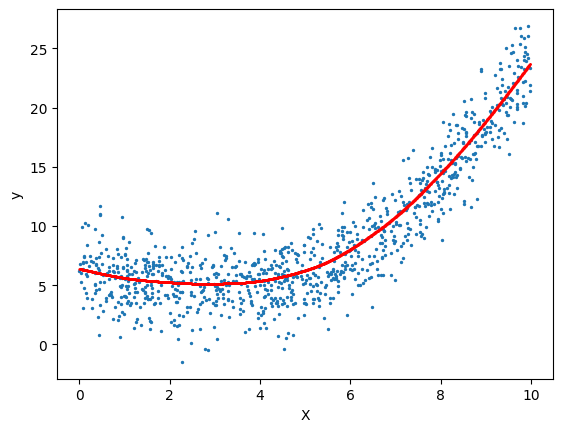

In [5]:
regressor = Local_weighted_linear_regressor()
regressor.fit(x, y)
regressor.plot_fig()

In [4]:
for width in range(5, 15):
    regressor = Local_weighted_linear_regressor(width)
    regressor.fit(x_train, y_train)
    y_test_predict = regressor.predict(x_test)
    print(width, mse_loss(y_test_predict, y_test))

5 17932.728383479476
6 17935.12815966288
7 17943.191990100844
8 17948.812191428722
9 17950.038595310725
10 17949.82540313124
11 17947.725258046514
12 17945.253771760188
13 17942.105013126526
14 17939.738492948174


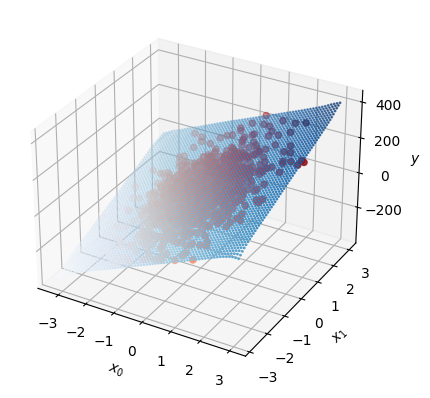

In [3]:
# regressor = Local_weighted_linear_regressor()
# regressor.fit(x_train, y_train)
# y_test_predict = regressor.predict(x_test)

# for width in range(2, 30):
#     regressor = Local_weighted_linear_regressor(width)
#     regressor.fit(x_train, y_train)
#     y_test_predict = regressor.predict(x_test)
#     print(width, mse_loss(y_test_predict, y_test))
regressor = Local_weighted_linear_regressor()
regressor.fit(x, y)
regressor.plot_fig()


In [31]:
for n_neigh in range(2, 30):
    regressor = KNN_linear_regressor(n_neighbors=n_neigh)
    regressor.fit(x_train, y_train)
    y_test_predict = regressor.predict(x_test)
    print(n_neigh, mse_loss(y_test_predict, y_test))

2 318.26940549595236
3 9.163652240600053
4 5.899410349940144
5 5.019088896737286
6 5.464684338015755
7 5.0137016716071665
8 4.84519215548906
9 4.655833844492685
10 4.590738536407569
11 4.634783896374189
12 4.69668464798644
13 4.556524052986122
14 4.550128900885043
15 4.535624333700789
16 4.477782171256519
17 4.362860784987353
18 4.448522152124436
19 4.351112330311611
20 4.317670246920984
21 4.277274244284932
22 4.259492513037255
23 4.172781709419151
24 4.130035878954019
25 4.098155870171876
26 4.126612978094681
27 4.151184705657666
28 4.102937134833682
29 4.082318511266777


In [66]:
for n_neigh in range(2, 30):
    regressor = KNN_linear_regressor(n_neighbors=n_neigh)
    regressor.fit(x_train, y_train)
    y_test_predict = regressor.predict(x_test)
    print(n_neigh, mse_loss(y_test_predict, y_test))

2 358.00781020763577
3 63.920155857135114
4 64.27499144198994
5 62.822040372808836
6 63.23295422070534
7 61.65382951252801
8 62.27033253137588
9 62.370646958614884
10 62.04616309563717
11 61.85149319955859
12 61.82487807086007
13 61.69863586226015
14 61.52514065027445
15 61.41293209951868
16 61.36068151898219
17 61.524601305104
18 61.698835273079936
19 61.81261773536087
20 61.94150209597356
21 61.808353193149635
22 61.81490953247269
23 61.794823395692
24 61.68033712019861
25 61.54618961880852
26 61.614891329703724
27 61.60844471321204
28 61.5022307008132
29 61.47553817350321


In [ ]:
def least_square(y, x_mat):
    a = x_mat.T.dot(x_mat)
    b = x_mat.T.dot(y)
    # print(a)
    # print(b)
    return np.linalg.solve(a,b)
def build_poly(x, degree):
    poly = np.ones((len(x), 1))
    for deg in range(1, degree + 1):
        poly = np.c_[poly, np.power(x, deg)]
    return poly
def mse_loss(a, b):
    return np.mean((a - b) ** 2)

for degree in range(10):
# degree = 4
    #x_mat = np.c_[np.ones(len(x_train)), x_train.squeeze()]
    x_mat = build_poly(x_train.squeeze(), degree)
    w = least_square(y_train.squeeze(), x_mat)

    # x_test_mat = np.c_[np.ones(len(x_test)), x_test.squeeze()]
    predict_y = np.matmul(x_test_mat, w)
    print(degree, mse_loss(predict_y, y_test))

27


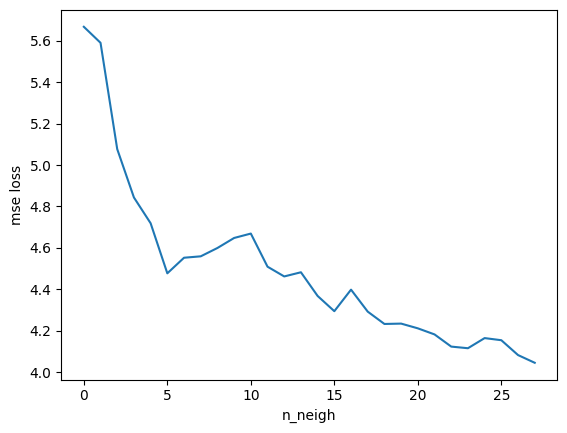

In [48]:
import matplotlib.pyplot as plt


plt.xlabel("n_neigh")
plt.ylabel("mse loss")
plt.plot(range(len(losses)), losses)
print(np.argmin(losses))

In [ ]:
x.shape

In [ ]:
data['X']

In [ ]:
data['y']